# ACT_Comfocus Case

The food industry is increasingly competitive, while 95% of products fail without consumer preference assessments (Buss, 2018). As people become more health-conscious, packages with health cues such as “low in fat” and popularity cues like “bestseller” (Wansink & Chandon, 2014) have significantly impact consumers' purchasing decisions (Stanhope & Havel, 2008; Spenner & Freeman, 2012). In this case, to minimize cognitive interference, we utilized NoldusHub to collect psycho-physiological data from consumers' reactions to various packaging designs. These data were combined with self-reports to investigate how health and popularity cues in packaging affect consumer preferences, thereby enhancing the understanding of consumer behavior.  

Our main research question is 'How do different food packaging designs predict consumer preference?'. To address it in more detail, two studies will be conducted to answer two sub-questions:  
- **Study 1**: Do different food packaging designs (i.e., health cue and popularity cue) significantly impact individuals' psycho-physiological responses and their preferences?    
- **Study 2**: Can psycho-physiological reactions predict consumer preference?  

***


All the relevant sections of this notebook are there, which could be regarded as an outline for this use case analysis.  
1. Data Loading  
2. Data Exploration  
    2.1 Data Cleaning  
    2.2 Individual Exploration  
3. Feature Engineering  
    3.1 EDA arousal ratio (EDA_AR)  
    3.2 Root Mean Square of Successive Differences (RMSSD)  
    3.3 Proportion of fixation duration (PFD)  
    3.4 Mean Value of Emotion (MVE)  
4. Aggregate Exploration  
    4.1 Average Emotion Scores by Package Type  
    4.2 EDA_AR, RMSSD and PFD for each Package Type  
5. Study 2_Mixed Effects Model  
    5.1 Heatmap  
***

## 1. Data Loading

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

In [2]:
# Load the Excel file
file_path = 'ResultsCandice_40_Hz.xlsx'

# Load the workbook and specify the sheet by its name
sheet_name = 'Data&Stim&ROI'

# Read the specific sheet into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)


## 2. Data Exploration

In [3]:
# Display the first 15 rows of the dataset
df.head(5)

,Date,Time,Time_0,Session,AR_Height,AR_Width,EDA_Peakrate,EDA_Tonic,FacialExpression_Angry,FacialExpression_Bored,...,FixationpointX,FixationpointY,x,InROI,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38
0,2024-01-31,2024-01-31 10:07:33,0.000,Bram_C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Xmin,Xmax,Ymin,Ymax
1,2024-01-31,2024-01-31 10:07:33,0.025,Bram_C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,FT,0.588021,0.639583,0.093519,0.201852
2,2024-01-31,2024-01-31 10:07:33,0.050,Bram_C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,CG,0.379167,0.429688,0.822222,0.909259
3,2024-01-31,2024-01-31 10:07:33,0.075,Bram_C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,HF,0.358333,0.516146,0.075,0.22963
4,2024-01-31,2024-01-31 10:07:33,0.100,Bram_C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,BS,0.378646,0.495833,0.350926,0.559259


In [4]:
# Check the shape of the dataset
# Print the number of rows and columns
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns')

The dataset contains 68760 rows and 39 columns


In [5]:
# Check the number of the observations for each participant ('Session')
df['Session'].value_counts()

Bregjie_C      3582
Juur_C         3495
Mira_C         3415
Valentijn_C    3365
Maxim_C        3289
Peuter_C       3272
Leonie_C       3203
Danique_C      3192
Lotte_C        3180
Maud_C         3169
Jeroen_C       3148
Pieter_C       3141
Lennard_C      3140
Wessel_C       3120
Bram_C         3041
Klaas_C        3018
Joep_C         3018
Noortje_C      2951
Tijn_C         2819
Stef_C         2784
Gijs_C         2742
Lieve_C        2676
Name: Session, dtype: int64

In [6]:
# Check the number of participants ('Session')
print("We have", df['Session'].nunique(), "participants in the dataset.")

We have 22 participants in the dataset.


### 2.1 Data Cleaning

#### 2.1.1 Regions of Interest

We observed that on the right-hand side, external to the 'target' dataset, there is a 5x6 matrix displaying the regions of interest for each package. To prevent potential misuse of this data in subsequent analyses, we established a separate dataset named `df_regions_all` for these entries and removed them from the original dataset (a.k.a., `df`).

In [7]:
# Create a dataframe (df_regions) for the regions of interest for each package.
df_regions = df.iloc[0:6, -5:]

# Change the column names of df_regions to 'Name_Logo', 'Xmin', 'Xmax', 'Ymin, and 'Ymax'
df_regions.columns = ['Name', 'Xmin', 'Xmax', 'Ymin', 'Ymax']

# Delete the first row of df_regions
df_regions = df_regions.drop(0, axis=0)

# Display the df_regions dataframe
df_regions


,Name,Xmin,Xmax,Ymin,Ymax
1,FT,0.588021,0.639583,0.093519,0.201852
2,CG,0.379167,0.429688,0.822222,0.909259
3,HF,0.358333,0.516146,0.075,0.22963
4,BS,0.378646,0.495833,0.350926,0.559259
5,All,0.452083,0.644792,0.610185,0.925


In [8]:
# Drop these columns from the original dataset, as they are included in df_regions
df = df.drop(['Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38'], axis=1)

#### 2.1.2 Empty columns

In [9]:
# Print the names of the columns that ONLY contain missing values (empty columns)
print(f'The columns that ONLY contain missing values (empty columns) are: {df.columns[df.isna().all()].tolist()}, \nwhich can be dropped from df.')

The columns that ONLY contain missing values (empty columns) are: ['x', 'Unnamed: 33'], 
which can be dropped from df.


In [10]:
# Drop columns that are not needed: 'x', 'Unnamed: 33' (columns entail only missing values)
df = df.drop(['x', 'Unnamed: 33'], axis=1)

#### 2.1.3 Missing values

In [11]:
#check for missing values
print(df.isna().sum())

Date                               0
Time                               0
Time_0                             0
Session                            0
AR_Height                        198
AR_Width                         198
EDA_Peakrate                   10015
EDA_Tonic                      10015
FacialExpression_Angry          1424
FacialExpression_Bored          4835
FacialExpression_Confused       2452
FacialExpression_Disgusted      1424
FacialExpression_Happy          1424
FacialExpression_Interested     2452
FacialExpression_Neutral        1424
FacialExpression_Sad            1424
FacialExpression_Scared         1424
FacialExpression_Surprised      1424
GazepointLeftX                   241
GazepointLeftY                   241
GazepointRightX                  214
GazepointRightY                  214
GazepointX                       208
GazepointY                       208
MovementState                     79
PPG_Heartrate                  11529
PPGHeartRateSelected               0
P

Now we check the missing values in some specific features that will be used in the subsequent analyses, and deal with them in appropriate ways.

In [12]:
# EDA Tonic

# Check the total number of values for each participant in 'EDA_Tonic'
total_values = df.groupby('Session')['EDA_Tonic'].count()
print("Total number of non-missing values for each participant in 'EDA_Tonic': \n(If the number equals 0, it means that the participant has NO values in 'EDA_Tonic').")
print(total_values)

# Check for rows with missing EDA_Tonic but non-missing EventRene
missing_eda = df[df['EDA_Tonic'].isna() & df['EventRene'].notna()]

# Print the unique values in 'Session' of these rows
unique_sessions = missing_eda['Session'].unique()

# Print a space line
print("\n")

print("Participants with missing EDA_Tonic when EventRene are not missed:")
print(unique_sessions)

# Print the exact number of missing values in 'EDA_Tonic' for each unique session
missing_counts = missing_eda['Session'].value_counts()
for session in unique_sessions:
    print(f"{session} has {missing_counts[session]} missing values in 'EDA_Tonic'")


Total number of non-missing values for each participant in 'EDA_Tonic': 
(If the number equals 0, it means that the participant has NO values in 'EDA_Tonic').
Session
Bram_C         2856
Bregjie_C      3407
Danique_C      3021
Gijs_C         2580
Jeroen_C       2979
Joep_C         2769
Juur_C         3315
Klaas_C        2837
Lennard_C      2961
Leonie_C       3039
Lieve_C        2493
Lotte_C           0
Maud_C         2989
Maxim_C           0
Mira_C         3242
Noortje_C      2814
Peuter_C       3098
Pieter_C       2961
Stef_C         2592
Tijn_C         2646
Valentijn_C    3197
Wessel_C       2949
Name: EDA_Tonic, dtype: int64


Participants with missing EDA_Tonic when EventRene are not missed:
['Lotte_C' 'Maxim_C']
Lotte_C has 1200 missing values in 'EDA_Tonic'
Maxim_C has 1200 missing values in 'EDA_Tonic'


In [13]:
# HR Interval
# Check for rows with missing PPG_Interbeatinterval but non-missing EventRene
missing_interval = df[df['PPG_Interbeatinterval'].isna() & df['EventRene'].notna()]
 
# Print the unique values in 'Session' of these rows
unique_sessions = missing_interval['Session'].unique()
print("Participants with missing PPG_Interbeatinterval when EventRene are not missed:")
print(unique_sessions)
 
# Print the exact number of missing values in 'PPG_Interbeatinterval' for each unique session
missing_counts = missing_interval['Session'].value_counts()
for session in unique_sessions:
    print(f"{session} has {missing_counts[session]} missing values in 'PPG_Interbeatinterval'")



Participants with missing PPG_Interbeatinterval when EventRene are not missed:
['Lennard_C' 'Lotte_C' 'Maud_C' 'Maxim_C' 'Stef_C']
Lennard_C has 480 missing values in 'PPG_Interbeatinterval'
Lotte_C has 1200 missing values in 'PPG_Interbeatinterval'
Maud_C has 69 missing values in 'PPG_Interbeatinterval'
Maxim_C has 1200 missing values in 'PPG_Interbeatinterval'
Stef_C has 148 missing values in 'PPG_Interbeatinterval'


In [14]:
# Movement State
# Check for rows with missing MovementState but non-missing EventRene
missing_MovementState = df[df['MovementState'].isna() & df['EventRene'].notna()]
 
# Print the unique values in 'Session' of these rows
unique_sessions = missing_MovementState['Session'].unique()
print("Participants with missing MovementState when EventRene are not missed:")
print(unique_sessions)
 
# Print the exact number of missing values in 'MovementState' for each unique session
missing_counts = missing_MovementState['Session'].value_counts()
for session in unique_sessions:
    print(f"{session} has {missing_counts[session]} missing values in 'MovementState'")



Participants with missing MovementState when EventRene are not missed:
[]


In [15]:
# Facial Expression
# Define the list of FacialExpression columns
facial_expression_columns = [
    'FacialExpression_Surprised', 'FacialExpression_Angry', 'FacialExpression_Bored',
    'FacialExpression_Confused', 'FacialExpression_Disgusted', 'FacialExpression_Happy',
    'FacialExpression_Interested', 'FacialExpression_Neutral', 'FacialExpression_Sad',
    'FacialExpression_Scared'
]

# Check for rows with missing values in each FacialExpression column but non-missing EventRene
for expression_column in facial_expression_columns:
    missing_expression = df[df[expression_column].isna() & df['EventRene'].notna()]
    
    # Print the unique values in 'Session' of these rows
    unique_sessions = missing_expression['Session'].unique()
    print(f"Participants with missing {expression_column} when EventRene are not missed:")
    print(unique_sessions)
    
    # Print the exact number of missing values in the FacialExpression column for each unique session
    missing_counts = missing_expression['Session'].value_counts()
    for session in unique_sessions:
        print(f"{session} has {missing_counts[session]} missing values in '{expression_column}'")

Participants with missing FacialExpression_Surprised when EventRene are not missed:
[]
Participants with missing FacialExpression_Angry when EventRene are not missed:
[]
Participants with missing FacialExpression_Bored when EventRene are not missed:
['Gijs_C' 'Peuter_C']
Gijs_C has 566 missing values in 'FacialExpression_Bored'
Peuter_C has 240 missing values in 'FacialExpression_Bored'
Participants with missing FacialExpression_Confused when EventRene are not missed:
['Gijs_C']
Gijs_C has 51 missing values in 'FacialExpression_Confused'
Participants with missing FacialExpression_Disgusted when EventRene are not missed:
[]
Participants with missing FacialExpression_Happy when EventRene are not missed:
[]
Participants with missing FacialExpression_Interested when EventRene are not missed:
['Gijs_C']
Gijs_C has 51 missing values in 'FacialExpression_Interested'
Participants with missing FacialExpression_Neutral when EventRene are not missed:
[]
Participants with missing FacialExpression_

In [16]:
# Appearance and disappearance of different packages (EventRene)
# List of required event types
required_event_types = ['CG', 'BS', 'FT', 'HF', 'All']

# Group by 'Session' and check if each group has all required event types
grouped = df.groupby('Session')['EventRene'].apply(lambda x: set(x) >= set(required_event_types))

# Find sessions that do not have all required event types
sessions_missing_types = grouped[~grouped].index.tolist()

if sessions_missing_types:
    print("participants who without the information about the time points for both the appearance and disappearance of different packages:")
    for session in sessions_missing_types:
        print(f"Session {session}")
else:
    print("All participants have all types (CG, BS, FT, HF, All).")

participants who without the information about the time points for both the appearance and disappearance of different packages:
Session Wessel_C


In summary, we're going to drop all the observations (rows) for six participants before the starting of Feature Engineering, including 'Lotte_C', 'Maxim_C', 'Lennard_C', 'Maud_C', 'Stef_C', and 'Wessel_C'. Here're the reasons for dropping them (in short):  
1. Lotte_C & Maxim_C: without values in EDA Tonic (`EDA_Tonic`) and HR Interval (`PPG_Interbeatinterval`).  
2. Lennard_C & Maud_C & Stef_C: without values in HR Interval (`PPG_Interbeatinterval`) on at least one packaging type.  
3. Wessel_C: without the information about the time points for both the appearance and disappearance of different packages (`EventRene`).  

Moreover, 'Gijs_C' and 'Peuter_C' don't have values in facial expression of Bored (`FacialExpression_Bored`), Confused (`FacialExpression_Confused`), and Interested (`FacialExpression_Interested`). Therefore, we will exclude these types of facial expressions in the subsequent analyses.  

#### 2.1.4 Unusual values

Here we check unusual values in some specific features that will be used in the subsequent analyses, and impute them in appropriate ways.

In [17]:
# EDA PeakRate

# Check the number of missing values in the columns 'EDA_Peakrate' in df
print(f'The number of missing values in the column "EDA_Peakrate" is: {df["EDA_Peakrate"].isna().sum()} out of {df["EDA_Peakrate"].count()}')

The number of missing values in the column "EDA_Peakrate" is: 10015 out of 58745


In [18]:
# Print the number of negative values in the column 'EDA_Peakrate'
print(f'The number of negative values in the column "EDA_Peakrate" is: {df[df["EDA_Peakrate"] < 0]["EDA_Peakrate"].count()} out of {df["EDA_Peakrate"].count()}')

The number of negative values in the column "EDA_Peakrate" is: 3748 out of 58745


In [19]:
# Create a new column 'Session_dropped' in df, 
# excluding the participants who will be dropped in the subsequent analysis, 
# including 'Lotte_C', 'Maxim_C', 'Lennard_C', 'Maud_C', 'Stef_C', and 'Wessel_C'


# Drop the participants 'Lotte_C', 'Maxim_C', 'Lennard_C', 'Maud_C', 'Stef_C', and 'Wessel_C' from 'Session_dropped'
df['Session_dropped'] = df['Session'].copy()
df['Session_dropped'] = df['Session_dropped'].replace(['Lotte_C', 'Maxim_C', 'Lennard_C', 'Maud_C', 'Stef_C', 'Wessel_C'], np.nan)


# Create a list of participants who have negative values in the column 'EDA_Peakrate'
negative_EDA_Peakrate = df[df['EDA_Peakrate'] < 0]['Session_dropped'].unique()

# Print the number of participants who have negative values in the column 'EDA_Peakrate',
# except for the participants who will be dropped from 'Sesion' column ('Lotte_C', 'Maxim_C', 'Lennard_C', 'Maud_C', 'Stef_C', and 'Wessel_C')
print(f'The number of participants who have negative values in the column "EDA_Peakrate" is: {len(negative_EDA_Peakrate)} out of {df["Session_dropped"].nunique()}')

# Delete the columns 'Session_dropped' from df after this checking
df = df.drop('Session_dropped', axis=1)

The number of participants who have negative values in the column "EDA_Peakrate" is: 14 out of 16


Given that approximately 88% of participants (14 out of 16) exhibit negative values in ‘EDA_Peakrate’, which are considered unusual according to the reference manual stating that EDA signal values should be positive, it is reasonable to conclude that the algorithm for measuring EDA PeakRate lacks reliability. Therefore, the feature of ‘EDA_Peakrate’ was excluded from the subsequent analysis, and skin conductance measurements were based on the EDA tonic component.

In [20]:
# InROI

# Change the column name of 'InROI' to 'ROI'
df = df.rename(columns={'InROI': 'ROI'})

# Impute this column into a binary column, where 'Y' is 1 and other values are 0
df['ROI'] = df['ROI'].apply(lambda x: 1 if x == 'Y' else 0)

In [21]:
# Facial expressions

# Check the number of unusual values in the columns for intensity of emotional expressions (all the columns for FacialExpression), 
# which are outside the range of 0 to 1.

# Create a dataframe (UN_emo) to check the specific 
# which only include these features for emotional expresison 'FacialExpression_Happy', 'FacialExpression_Interested', 'FacialExpression_Neutral', 'FacialExpression_Sad', 'FacialExpression_Scared', 'FacialExpression_Surprised', 'FacialExpression_Disgusted', 'FacialExpression_Angry', 'FacialExpression_Bored', 'FacialExpression_Confused'
UN_emo = df[['FacialExpression_Happy', 'FacialExpression_Interested', 'FacialExpression_Neutral', 'FacialExpression_Sad', 'FacialExpression_Scared', 'FacialExpression_Surprised', 'FacialExpression_Disgusted', 'FacialExpression_Angry', 'FacialExpression_Bored', 'FacialExpression_Confused']]

# Print the specific unusual values for every feature, not for the number of them
for col in UN_emo.columns:
    print(f'The unusual values for {col} are: {UN_emo[(UN_emo[col] < 0) | (UN_emo[col] > 1)][col].unique()}')

The unusual values for FacialExpression_Happy are: [-2.23682360e-09 -3.14836729e-08 -1.76162392e-08 ... -1.14238116e-12
 -8.08527839e-13 -7.60312104e-28]
The unusual values for FacialExpression_Interested are: [-2.28834526e-22 -2.43346231e-07 -3.43827556e-07 ... -2.79210748e-06
 -1.97613258e-06 -1.85828792e-21]
The unusual values for FacialExpression_Neutral are: [1.00086878 1.00000739 1.00152265 1.00243948 1.00122368 1.00196726]
The unusual values for FacialExpression_Sad are: [-8.65286398e-05 -1.82370783e-04 -2.26016674e-04 ... -2.77300448e-05
 -4.86204229e-03 -7.67644505e-03]
The unusual values for FacialExpression_Scared are: [-4.89107653e-06 -1.28937347e-05 -5.26070817e-05 ... -4.92562248e-11
 -5.13626239e-11 -2.01723074e-11]
The unusual values for FacialExpression_Surprised are: [-1.98417389e-22 -2.38843778e-07 -3.21420109e-07 ... -4.78107672e-12
 -3.38383873e-12 -3.18204695e-27]
The unusual values for FacialExpression_Disgusted are: [-4.57990932e-07 -9.37128540e-07 -1.58145360e-

In [22]:
# Print the specific values that are larger than 1 in the columns for intensity of emotional expressions in UN_emo
for col in UN_emo.columns:
    print(f'The values larger than 1 for {col} are: {UN_emo[UN_emo[col] > 1][col].unique()}')


The values larger than 1 for FacialExpression_Happy are: []
The values larger than 1 for FacialExpression_Interested are: []
The values larger than 1 for FacialExpression_Neutral are: [1.00086878 1.00000739 1.00152265 1.00243948 1.00122368 1.00196726]
The values larger than 1 for FacialExpression_Sad are: []
The values larger than 1 for FacialExpression_Scared are: []
The values larger than 1 for FacialExpression_Surprised are: []
The values larger than 1 for FacialExpression_Disgusted are: []
The values larger than 1 for FacialExpression_Angry are: []
The values larger than 1 for FacialExpression_Bored are: []
The values larger than 1 for FacialExpression_Confused are: []


In [23]:
# Print the exact number of unusual values in the columns for intensity of emotional expressions in UN_emo
for col in UN_emo.columns:
    print(f'The number of unusual values for {col} is: {UN_emo[(UN_emo[col] < 0) | (UN_emo[col] > 1)][col].nunique()}')


The number of unusual values for FacialExpression_Happy is: 12077
The number of unusual values for FacialExpression_Interested is: 1092
The number of unusual values for FacialExpression_Neutral is: 6
The number of unusual values for FacialExpression_Sad is: 5793
The number of unusual values for FacialExpression_Scared is: 14359
The number of unusual values for FacialExpression_Surprised is: 15179
The number of unusual values for FacialExpression_Disgusted is: 6274
The number of unusual values for FacialExpression_Angry is: 5238
The number of unusual values for FacialExpression_Bored is: 3007
The number of unusual values for FacialExpression_Confused is: 3317


In [24]:
# Print the total number of unusual values that are larger than 1, and smaller than 0,
# in the columns for intensity of emotional expressions in UN_emo separately
print(f'Total number of unusual values > 1 in the intensity of emotional expressions is: {UN_emo[UN_emo > 1].count().sum()}')
print(f'Total number of unusual values < 0 in the intensity of emotional expressions is: {UN_emo[UN_emo < 0].count().sum()}')

Total number of unusual values > 1 in the intensity of emotional expressions is: 6
Total number of unusual values < 0 in the intensity of emotional expressions is: 66336


In [25]:
# Print the total number of values in the columns for intensity of emotional expressions in UN_emo
print(f'The total number of values in the columns for intensity of emotional expressions is: {UN_emo.count().sum()}')

The total number of values in the columns for intensity of emotional expressions is: 667893


[Reasons for imputation and the selection of methods for imputation]

In [26]:
# Impute the unusual values larger than 1 with 1, and the unusual values smaller than 0 with 0
# in the original dataset (df) for columns 'FacialExpression_Happy', 'FacialExpression_Interested', 'FacialExpression_Neutral', 'FacialExpression_Sad', 'FacialExpression_Scared', 'FacialExpression_Surprised', 'FacialExpression_Disgusted', 'FacialExpression_Angry', 'FacialExpression_Bored', 'FacialExpression_Confused'

# Define the columns to be imputed
cols = ['FacialExpression_Happy', 'FacialExpression_Interested', 'FacialExpression_Neutral', 'FacialExpression_Sad', 'FacialExpression_Scared', 'FacialExpression_Surprised', 'FacialExpression_Disgusted', 'FacialExpression_Angry', 'FacialExpression_Bored', 'FacialExpression_Confused']

# Impute the unusual values larger than 1 with 1, and the unusual values smaller than 0 with 0
for col in cols:
    df[col] = np.where(df[col] > 1, 1, df[col])
    df[col] = np.where(df[col] < 0, 0, df[col])

In [27]:
# Print the total number of unusual values that are larger than 1, and smaller than 0,
# in the columns for intensity of emotional expressions in cols in df separately
print(f'Total number of unusual values > 1 in the intensity of emotional expressions in df is: {df[df[cols] > 1].count().sum()}')
print(f'Total number of unusual values < 0 in the intensity of emotional expressions in df is: {df[df[cols] < 0].count().sum()}')

# If all the numbers are 0, then we succeeded in imputing the unusual values in the columns for intensity of emotional expressions in cols in df

Total number of unusual values > 1 in the intensity of emotional expressions in df is: 0
Total number of unusual values < 0 in the intensity of emotional expressions in df is: 0


#### 2.1.5 Duplicated rows

In [28]:
# Check the duplicated rows in the dataset (df)
# Print the number of duplicated rows
print(f'The number of duplicated rows in the dataset is: {df.duplicated().sum()}')

The number of duplicated rows in the dataset is: 0


### 2.2 Individual Exploration

In [29]:
# SUBSET CREATION: Bregjie_C
# Subset for Bregjie
Bregjie = df[(df['Session'] == 'Bregjie_C')]
Bregjie.head(5)

,Date,Time,Time_0,Session,AR_Height,AR_Width,EDA_Peakrate,EDA_Tonic,FacialExpression_Angry,FacialExpression_Bored,...,GazepointX,GazepointY,MovementState,PPG_Heartrate,PPGHeartRateSelected,PPG_Interbeatinterval,EventRene,FixationpointX,FixationpointY,ROI
3041,2024-01-31,2024-01-31 10:54:44,0.000,Bregjie_C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,missing,NaN,NaN,NaN,NaN,0
3042,2024-01-31,2024-01-31 10:54:44,0.025,Bregjie_C,1080.0,1920.0,NaN,NaN,NaN,NaN,...,0.159195,0.894648,UNDEFINED,NaN,missing,NaN,NaN,NaN,NaN,0
3043,2024-01-31,2024-01-31 10:54:44,0.050,Bregjie_C,1080.0,1920.0,NaN,NaN,NaN,NaN,...,0.142638,0.909638,UNDEFINED,NaN,missing,NaN,NaN,NaN,NaN,0
3044,2024-01-31,2024-01-31 10:54:44,0.075,Bregjie_C,1080.0,1920.0,NaN,NaN,NaN,NaN,...,0.137168,0.914430,UNDEFINED,NaN,missing,NaN,NaN,NaN,NaN,0
3045,2024-01-31,2024-01-31 10:54:44,0.100,Bregjie_C,1080.0,1920.0,NaN,NaN,NaN,NaN,...,0.159854,0.893307,UNDEFINED,NaN,missing,NaN,NaN,NaN,NaN,0


In [30]:
# Create subsets on Bram per packaging type (BS, HF, FT, All), including the interval between each packaging type
# Packaging type FT acts as the control group and will be compared against BS and HF, which include the popularity and health cue, respectively.
pbregjie = Bregjie[(Bregjie['Time_0'] >= 47.2) & (Bregjie['Time_0'] <= 83.2)]
pbregjie.head(5)

,Date,Time,Time_0,Session,AR_Height,AR_Width,EDA_Peakrate,EDA_Tonic,FacialExpression_Angry,FacialExpression_Bored,...,GazepointX,GazepointY,MovementState,PPG_Heartrate,PPGHeartRateSelected,PPG_Interbeatinterval,EventRene,FixationpointX,FixationpointY,ROI
4929,2024-01-31,2024-01-31 10:55:31,47.200,Bregjie_C,1080.0,1920.0,10.004083,4.689494,0.001558,0.144192,...,0.536345,0.756234,FIXATION,57.471312,57.471312,1043.835924,NaN,0.546078,0.742255,0
4930,2024-01-31,2024-01-31 10:55:31,47.225,Bregjie_C,1080.0,1920.0,9.998873,4.688576,0.001627,0.144274,...,0.538905,0.742665,FIXATION,57.456716,57.456716,1044.051361,NaN,0.547372,0.730758,0
4931,2024-01-31,2024-01-31 10:55:31,47.250,Bregjie_C,1080.0,1920.0,9.997019,4.688458,0.001685,0.144350,...,0.541475,0.730809,FIXATION,57.459669,57.459669,1044.043360,NaN,0.548654,0.718453,0
4932,2024-01-31,2024-01-31 10:55:31,47.275,Bregjie_C,1080.0,1920.0,9.998518,4.689141,0.001737,0.144446,...,0.544035,0.720624,FIXATION,57.453830,57.45383,1044.147160,NaN,0.549931,0.706648,0
4933,2024-01-31,2024-01-31 10:55:31,47.300,Bregjie_C,1080.0,1920.0,9.992259,4.688325,0.001812,0.144525,...,0.545812,0.711514,SACCADE,57.439236,57.439236,1044.363193,NaN,0.551051,0.696722,0


In [31]:
# For column named 'EventRene', impute all the missing values to 'Interval'
# store the imputed values in a new column named 'EventRene_imputed' in pbregjie
pbregjie['EventRene_imputed'] = pbregjie['EventRene'].fillna('Interval')

/var/folders/0r/j3pt0gxd59db062x60vqtsmr0000gn/T/ipykernel_68316/2963103630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbregjie['EventRene_imputed'] = pbregjie['EventRene'].fillna('Interval')


In [32]:
pbregjie['EDA_Peakrate'].value_counts()

10.004083    1
10.785647    1
10.793368    1
10.797301    1
10.802857    1
            ..
11.113350    1
11.118865    1
11.127788    1
11.129347    1
11.584907    1
Name: EDA_Peakrate, Length: 1441, dtype: int64

Here we created a line chart for transitions in intensity of emotional expressions at indivudual level (for one participant: Bregjie).

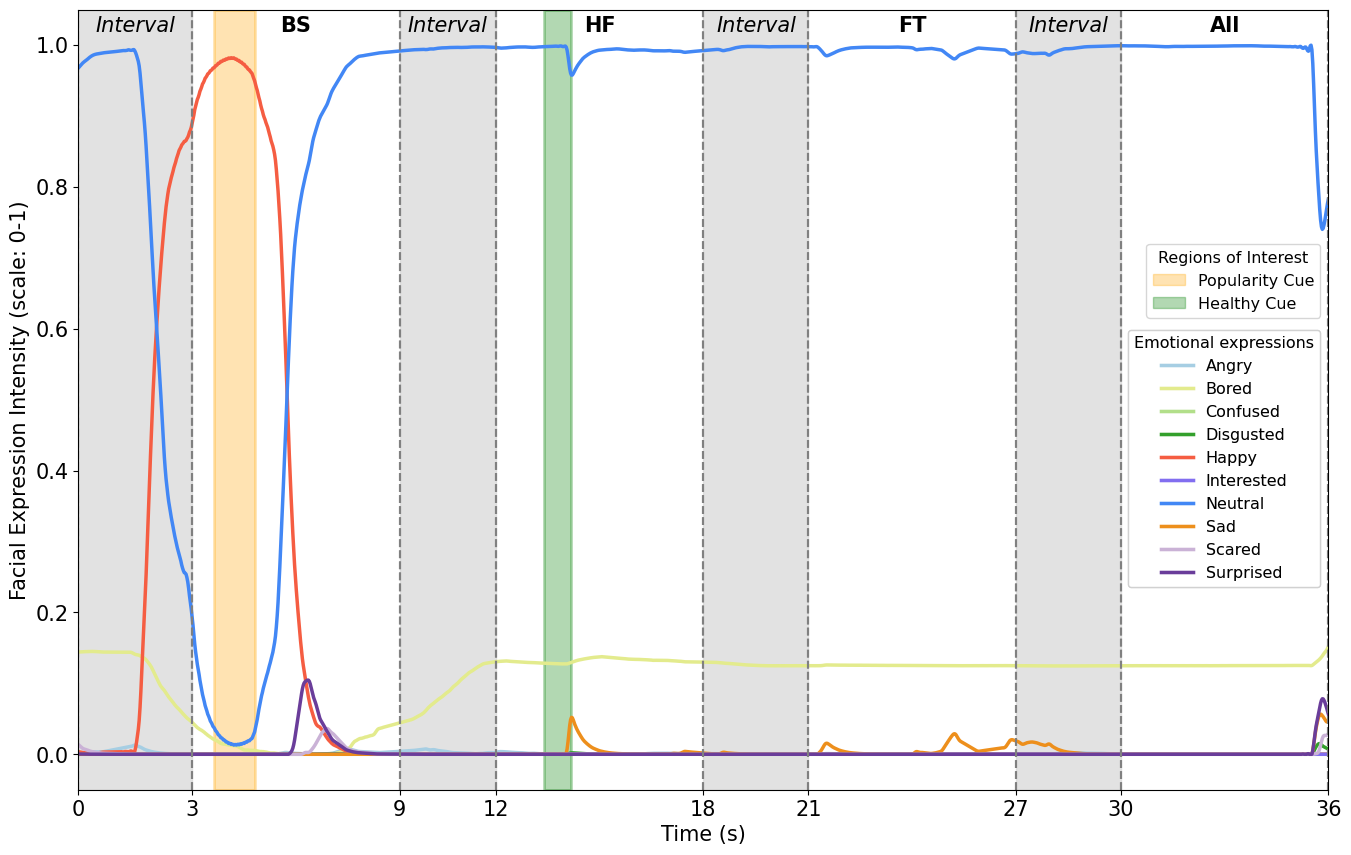

In [33]:
# Get the time indices of Bregjie
pbregjie_with_index = pbregjie.set_index('Time_0').copy()

# Define the size of the plot
fig, ax = plt.subplots(figsize=(20, 12))



# Plotting facial expressions with color theme 'Paired'
colors = plt.get_cmap('Paired').colors
emotion_labels = ['Angry', 'Bored', 'Confused', 'Disgusted', 'Happy', 'Interested', 'Neutral', 'Sad', 'Scared', 'Surprised']
emotion_colors = {
    'Angry': colors[0],
    'Bored': '#e3eb8d',  # custom color
    'Confused': colors[2],
    'Disgusted': colors[3],
    'Happy': '#f55d42',  # custom color
    'Interested': '#826ef0',  # custom color
    'Neutral': '#4287f5',  # custom color
    'Sad': '#ed8f1c',  # custom color
    'Scared': colors[8],
    'Surprised': colors[9]
}

for emotion, color in emotion_colors.items():
    plt.plot(pbregjie.index, pbregjie[f'FacialExpression_{emotion}'], label=emotion, color=color, linewidth=2.5)



# Finding the start and end indices for each event
event_lines = {
    # 'Interval': (pbregjie[pbregjie['EventRene_imputed'] == 'Interval'].index[0], pbregjie[pbregjie['EventRene_imputed'] == 'Interval'].index[-1]),
    'BS': (pbregjie[pbregjie['EventRene_imputed'] == 'BS'].index[0], pbregjie[pbregjie['EventRene_imputed'] == 'BS'].index[-1]),
    'HF': (pbregjie[pbregjie['EventRene_imputed'] == 'HF'].index[0], pbregjie[pbregjie['EventRene_imputed'] == 'HF'].index[-1]),
    'FT': (pbregjie[pbregjie['EventRene_imputed'] == 'FT'].index[0], pbregjie[pbregjie['EventRene_imputed'] == 'FT'].index[-1]),
    'All': (pbregjie[pbregjie['EventRene_imputed'] == 'All'].index[0], pbregjie[pbregjie['EventRene_imputed'] == 'All'].index[-1])
}

# Adding Interval event lines
interval_events = {
    'Interval0': (pbregjie[pbregjie['EventRene_imputed'] == 'Interval'].index[0], event_lines['BS'][0]),
    'Interval1': (event_lines['BS'][1], event_lines['HF'][0]),
    'Interval2': (event_lines['HF'][1], event_lines['FT'][0]),
    'Interval3': (event_lines['FT'][1], event_lines['All'][0])
}

# Plotting event lines
ax.axvline(x=interval_events['Interval0'][0], color='gray', linestyle='--')
for event, (start, end) in event_lines.items():
    ax.axvline(x=start, color='gray', linestyle='--')
    ax.axvline(x=end, color='gray', linestyle='--')
for interval, (start, end) in interval_events.items():
    ax.axvline(x=start, color='gray', linestyle='--')
    ax.axvline(x=end, color='gray', linestyle='--')
ax.axvline(x=pbregjie.index[-1], color='gray', linestyle='--')



# Adding segment labels within the plot, just below the upper limit of the y-axis
for event, (start, end) in event_lines.items():
    ax.text((start + end) / 2, ax.get_ylim()[1] * 0.97, event, ha='center', fontsize=15, fontweight='bold')

for interval, (start, end) in interval_events.items():
    ax.text((start + end) / 2, ax.get_ylim()[1] * 0.97, 'Interval', ha='center', fontsize=15, fontstyle='italic')


# Define the start and end indices for each 'Interval' area
interval_start0 = interval_events['Interval0'][0]
interval_end0 = event_lines['BS'][0]
interval_start1 = event_lines['BS'][1]
interval_end1 = event_lines['HF'][0]
interval_start2 = event_lines['HF'][1]
interval_end2 = event_lines['FT'][0]
interval_start3 = event_lines['FT'][1]
interval_end3 = event_lines['All'][0]

# Adding shaded backgrounds for 'Interval' areas
ax.axvspan(interval_start0, interval_end0, color='lightgray', alpha=0.65, label='_nolegend_') # alpha is the transparency level
ax.axvspan(interval_start1, interval_end1, color='lightgray', alpha=0.65, label='_nolegend_') 
ax.axvspan(interval_start2, interval_end2, color='lightgray', alpha=0.65, label='_nolegend_')
ax.axvspan(interval_start3, interval_end3, color='lightgray', alpha=0.65, label='_nolegend_')


# Customizing the x-axis labels
xticks = [interval_events['Interval0'][0], event_lines['BS'][0], event_lines['BS'][1], event_lines['HF'][0], event_lines['HF'][1], event_lines['FT'][0], event_lines['FT'][1], event_lines['All'][0], pbregjie.index[-1]]
xlabels = ['0', '3', '9', '12', '18', '21', '27', '30', '36']

# Set the x-axis ticks
ax.set_xticks(xticks)
# Change the size of the ticks on x-axis
plt.xticks(fontsize=15)

# Set the x-axis tick labels
ax.set_xticklabels(xlabels)
# Change the size of the labels on x-axis
plt.xticks(fontsize=15)



# Filtering the 'BS' and 'HF' areas for ROI == 1
bs_start = event_lines['BS'][0]
bs_end = event_lines['BS'][1]
hf_start = event_lines['HF'][0]
hf_end = event_lines['HF'][1]

# Define the range of ROI == 1 within 'BS' and 'HF'
bs_roi_1 = pbregjie[(pbregjie.index >= bs_start) & (pbregjie.index <= bs_end) & (pbregjie['ROI'] == 1)]
hf_roi_1 = pbregjie[(pbregjie.index >= hf_start) & (pbregjie.index <= hf_end) & (pbregjie['ROI'] == 1)]



# Adding orange shading for ROI == 1 within 'BS' and making lines thicker in shaded areas
roi_start = None
for i, (index, row) in enumerate(bs_roi_1.iterrows()):
    if row['ROI'] == 1 and roi_start is None:
        roi_start = index
    if row['ROI'] != 1 and roi_start is not None:
        ax.axvspan(roi_start, index, color='orange', alpha=0.3, label='_nolegend_', linewidth=2)
        roi_start = None
# If ROI == 1 ends at the end of the segment
if roi_start is not None:
    ax.axvspan(roi_start, bs_roi_1.index[-1], color='orange', alpha=0.3, label='_nolegend_', linewidth=2)


# Adding green shading for ROI == 1 within 'HF' and making lines thicker in shaded areas
roi_start = None
for i, (index, row) in enumerate(hf_roi_1.iterrows()):
    if row['ROI'] == 1 and roi_start is None:
        roi_start = index
    if row['ROI'] != 1 and roi_start is not None:
        ax.axvspan(roi_start, index, color='green', alpha=0.3, label='_nolegend_', linewidth=2)
        roi_start = None
# If ROI == 1 ends at the end of the segment
if roi_start is not None:
    ax.axvspan(roi_start, hf_roi_1.index[-1], color='green', alpha=0.3, label='_nolegend_', linewidth=2)





plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Facial Expression Intensity (scale: 0-1)', fontsize=15)
# Change the size of the ticks on y-axis
plt.yticks(fontsize=15)
# Turn off the grid
ax.grid(False)



# Set legends for emotional expressions
handles1 = [plt.Line2D([0], [0], color=color, lw=2.5) for color in emotion_colors.values()]
labels1 = emotion_colors.keys()

# Set legend for interesting areas in each packaging types (shaded areas)
orange_patch = mpatches.Patch(color='orange', alpha=0.3, label='Popularity Cue')
green_patch = mpatches.Patch(color='green', alpha=0.3, label='Healthy Cue')

# Put legends within the right side of FT event area
legend_packaging = plt.legend(handles=[orange_patch, green_patch], loc='upper right', bbox_to_anchor=(1.00, 0.71), title='Regions of Interest', fontsize=11.5, title_fontsize=11.5)
legend_emotions = ax.legend(handles=handles1, labels=labels1, loc='upper right', bbox_to_anchor=(1.00, 0.6), ncol=1, title='Emotional expressions', fontsize=11.5, title_fontsize=11.5)

# Add the legends to the plot
ax.add_artist(legend_packaging)
ax.add_artist(legend_emotions)

# Adjust the x-axis limits to fit the events exactly
ax.set_xlim([interval_events['Interval0'][0], pbregjie.index[-1]])

# Adjust layout
plt.subplots_adjust(top=0.85, bottom=0.2, right=0.75)

# Remove the background color
fig.patch.set_facecolor('white')

# Show the plot
plt.show()

We normalized the features 'EDA_Peakrate' and 'PPG_HeartRateSelected' by individually scaling each feature using the `MinMaxScaler()`, thereby ensuring that both features fall within the range of 0 to 1. This method allows us to accurately capture and compare transitions in consumers' EDA and HR levels within the same line chart.  

Unlike methods like Z-score normalization that remove the mean and scale to unit variance, `MinMaxScaler()` preserves the original data distribution by linearly scaling all values into a fixed range without reducing the effect of outliers. This approach ensures that the largest data point corresponds to the maximum value and the smallest data point corresponds to the minimum value, thus maintaining the relative differences between data points. Consequently, `MinMaxScaler()` ensures that no information is lost from the original data, making it ideal for scenarios where preserving the original data characteristics is crucial for analysis and interpretation.  

Here's the formula of `MinMaxScaler()`, with X as the original data and min and max as the desired minimum and maximum values of the scaled data:  
X_scaled = [(X - X_min) / (X_max - X_min)] * (max - min) + min  

Now we plot a line chart with the normalized data, for the transitions in physiological reactions at individual level (for one participant: Bregjie).

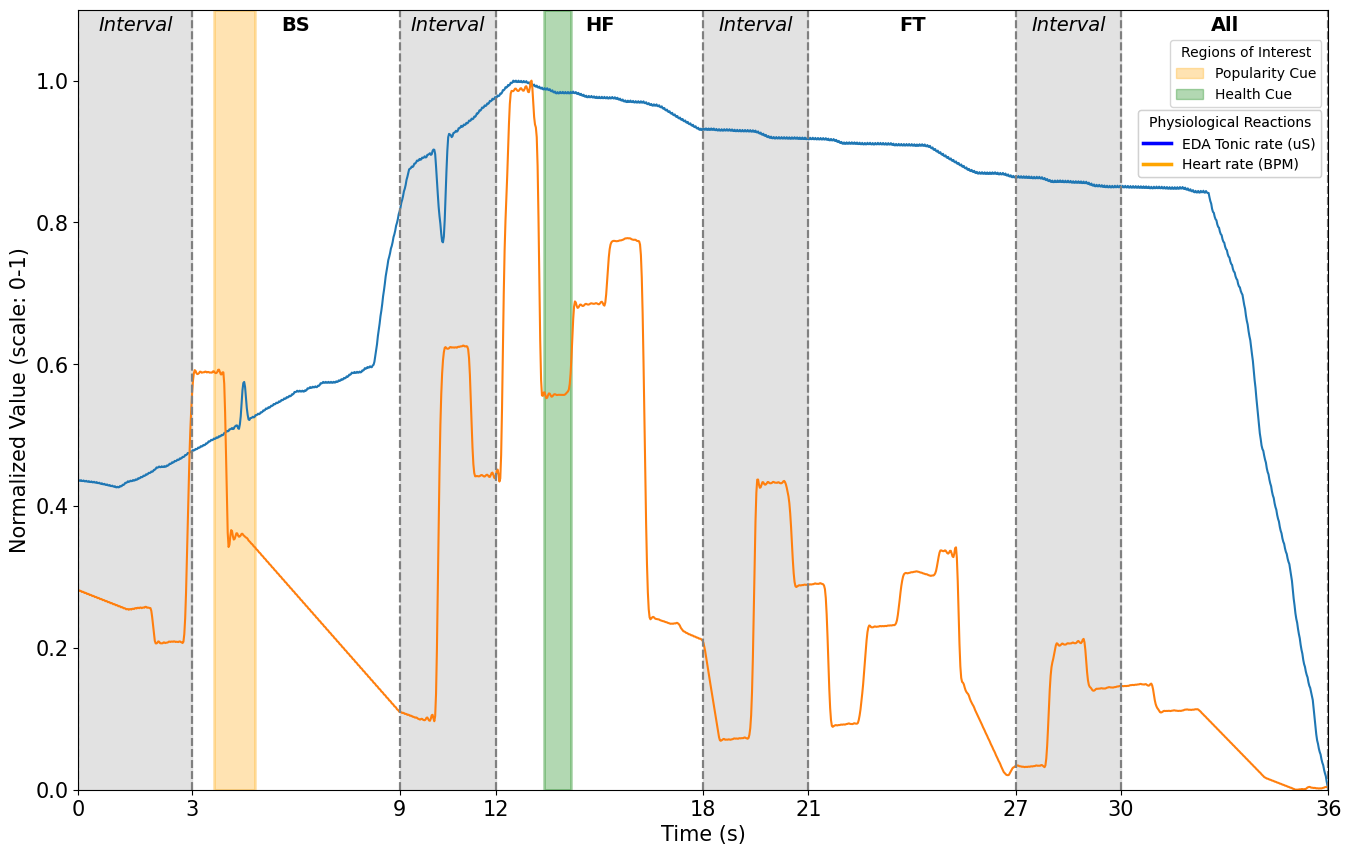

In [34]:
# Set Time_0 as index and create a copy
pbregjie_with_index = pbregjie.set_index('Time_0').copy()

# Replace 'missing' with NaN
pbregjie_with_index.replace('missing', pd.NA, inplace=True)

# Convert the columns to numeric, forcing errors to NaN
pbregjie_with_index[['EDA_Tonic', 'PPGHeartRateSelected']] = pbregjie_with_index[['EDA_Tonic', 'PPGHeartRateSelected']].apply(pd.to_numeric, errors='coerce')

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
features = ['EDA_Tonic', 'PPGHeartRateSelected']
imputed_data = imputer.fit_transform(pbregjie_with_index[features])

# Normalize the data between 0 and 1
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(imputed_data)

# Create a DataFrame with the normalized data
new_features = ['EDA Tonic rate (uS)', 'Heart rate (BPM)']
normalized_df = pd.DataFrame(normalized_data, columns=new_features, index=pbregjie_with_index.index)



# Define the size of the plot
fig, ax = plt.subplots(figsize=(20, 12))

# Plot normalized EDA and PPG data
for column in new_features:
    plt.plot(normalized_df.index, normalized_df[column], label=column)




# Finding the start and end indices for each event
event_lines = {
    # 'Interval': (pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'Interval'].index[0], pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'Interval'].index[-1]),
    'BS': (pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'BS'].index[0], pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'BS'].index[-1]),
    'HF': (pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'HF'].index[0], pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'HF'].index[-1]),
    'FT': (pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'FT'].index[0], pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'FT'].index[-1]),
    'All': (pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'All'].index[0], pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'All'].index[-1])
}

# Adding Interval event lines
interval_events = {
    'Interval0': (pbregjie_with_index[pbregjie_with_index['EventRene_imputed'] == 'Interval'].index[0], event_lines['BS'][0]),
    'Interval1': (event_lines['BS'][1], event_lines['HF'][0]),
    'Interval2': (event_lines['HF'][1], event_lines['FT'][0]),
    'Interval3': (event_lines['FT'][1], event_lines['All'][0])
}

# Plotting event lines
ax.axvline(x=interval_events['Interval0'][0], color='gray', linestyle='--')
for event, (start, end) in event_lines.items():
    ax.axvline(x=start, color='gray', linestyle='--')
    ax.axvline(x=end, color='gray', linestyle='--')
for interval, (start, end) in interval_events.items():
    ax.axvline(x=start, color='gray', linestyle='--')
    ax.axvline(x=end, color='gray', linestyle='--')
ax.axvline(x=pbregjie_with_index.index[-1], color='gray', linestyle='--')

# Adding segment labels within the plot, just below the upper limit of the y-axis
for event, (start, end) in event_lines.items():
    ax.text((start + end) / 2, ax.get_ylim()[1] * 1.02, event, ha='center', fontsize=14, fontweight='bold')

for interval, (start, end) in interval_events.items():
    ax.text((start + end) / 2, ax.get_ylim()[1] * 1.02, 'Interval', ha='center', fontsize=14, fontstyle='italic')

# Define the start and end indices for each 'Interval' area
interval_start0 = interval_events['Interval0'][0]
interval_end0 = event_lines['BS'][0]
interval_start1 = event_lines['BS'][1]
interval_end1 = event_lines['HF'][0]
interval_start2 = event_lines['HF'][1]
interval_end2 = event_lines['FT'][0]
interval_start3 = event_lines['FT'][1]
interval_end3 = event_lines['All'][0]

# Adding shaded backgrounds for 'Interval' areas
ax.axvspan(interval_start0, interval_end0, color='lightgray', alpha=0.65, label='_nolegend_') # alpha is the transparency level
ax.axvspan(interval_start1, interval_end1, color='lightgray', alpha=0.65, label='_nolegend_') 
ax.axvspan(interval_start2, interval_end2, color='lightgray', alpha=0.65, label='_nolegend_')
ax.axvspan(interval_start3, interval_end3, color='lightgray', alpha=0.65, label='_nolegend_')

# Customizing the x-axis labels
xticks = [interval_events['Interval0'][0], event_lines['BS'][0], event_lines['BS'][1], event_lines['HF'][0], event_lines['HF'][1], event_lines['FT'][0], event_lines['FT'][1], event_lines['All'][0], pbregjie_with_index.index[-1]]
xlabels = ['0', '3', '9', '12', '18', '21', '27', '30', '36']




# Set the x-axis ticks
ax.set_xticks(xticks)
# Change the size of the ticks on x-axis
plt.xticks(fontsize=15)

# Set the x-axis tick labels
ax.set_xticklabels(xlabels)
# Change the size of the labels on x-axis
plt.xticks(fontsize=15)



# Filtering the 'BS' and 'HF' areas for ROI == 1
bs_start = event_lines['BS'][0]
bs_end = event_lines['BS'][1]
hf_start = event_lines['HF'][0]
hf_end = event_lines['HF'][1]

# Define the range of ROI == 1 within 'BS' and 'HF'
bs_roi_1 = pbregjie_with_index[(pbregjie_with_index.index >= bs_start) & (pbregjie_with_index.index <= bs_end) & (pbregjie_with_index['ROI'] == 1)]
hf_roi_1 = pbregjie_with_index[(pbregjie_with_index.index >= hf_start) & (pbregjie_with_index.index <= hf_end) & (pbregjie_with_index['ROI'] == 1)]

# Adding orange shading for ROI == 1 within 'BS' and making lines thicker in shaded areas
roi_start = None
for i, (index, row) in enumerate(bs_roi_1.iterrows()):
    if row['ROI'] == 1 and roi_start is None:
        roi_start = index
    if row['ROI'] != 1 and roi_start is not None:
        ax.axvspan(roi_start, index, color='orange', alpha=0.3, label='_nolegend_', linewidth=2)
        roi_start = None
# If ROI == 1 ends at the end of the segment
if roi_start is not None:
    ax.axvspan(roi_start, bs_roi_1.index[-1], color='orange', alpha=0.3, label='_nolegend_', linewidth=2)

# Adding green shading for ROI == 1 within 'HF' and making lines thicker in shaded areas
roi_start = None
for i, (index, row) in enumerate(hf_roi_1.iterrows()):
    if row['ROI'] == 1 and roi_start is None:
        roi_start = index
    if row['ROI'] != 1 and roi_start is not None:
        ax.axvspan(roi_start, index, color='green', alpha=0.3, label='_nolegend_', linewidth=2)
        roi_start = None
# If ROI == 1 ends at the end of the segment
if roi_start is not None:
    ax.axvspan(roi_start, hf_roi_1.index[-1], color='green', alpha=0.3, label='_nolegend_', linewidth=2)


plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Normalized Value (scale: 0-1)', fontsize=15)
# Change the size of the ticks on y-axis
plt.yticks(fontsize=15)
# Turn off the grid
ax.grid(False)

# Set legend for EDA and PPG data
handles1 = [plt.Line2D([0], [0], color=color, lw=2.5) for color in ['blue', 'orange']]
labels1 = new_features

# Set legend for interesting areas in each packaging types (shaded areas)
orange_patch = mpatches.Patch(color='orange', alpha=0.3, label='Popularity Cue')
green_patch = mpatches.Patch(color='green', alpha=0.3, label='Health Cue')

# Put legends within the right side of FT event area
legend_packaging = plt.legend(handles=[orange_patch, green_patch], loc='upper right', bbox_to_anchor=(1.00, 0.97), title='Regions of Interest', fontsize=10, title_fontsize=10)
legend_signals = ax.legend(handles=handles1, labels=labels1, loc='upper right', bbox_to_anchor=(1.00, 0.88), ncol=1, title='Physiological Reactions', fontsize=10, title_fontsize=10)

# Add the legends to the plot
ax.add_artist(legend_packaging)
ax.add_artist(legend_signals)



# Adjust the x-axis limits to fit the events exactly
ax.set_xlim([interval_events['Interval0'][0], pbregjie_with_index.index[-1]])

# Adjust layout
plt.subplots_adjust(top=0.85, bottom=0.2, right=0.75)


# Remove the background color
fig.patch.set_facecolor('white')

# Set y-axis limits
plt.ylim(0, 1.1)

# Show the plot
plt.show()

## 3. Feature Engineering

To generate individualized summaries across time for each participant and avoid the expense of losing insights into individual differences, we developed several comparative features based on established literature and calculated their values for each participant. By calculating the average values of these comparative features for each time phase (i.e., Baseline, Popularity cue, …) or each packaging type, we provide inputs for subsequent data analysis algorithms. This approach facilitates comparison of consumers' psycho-physiological levels across all packaging types and phases, enabling longitudinal analysis at the aggregate level.

As explained in previous section (2.1.3), we're going to delete the observations of 'Lotte_C', 'Maxim_C', 'Lennard_C', 'Maud_C', and 'Stef_C', because they lacked data for the features that will be used in this section.

In [35]:
# Create a new dataframe (df_clean), 
# which excludes the observations of 'Lotte_C', 'Maxim_C', 'Lennard_C', 'Maud_C', 'Stef_C', and 'Wessel_C' in the 'Session' column
df_clean = df[~df['Session'].isin(['Lotte_C', 'Maxim_C', 'Lennard_C', 'Maud_C', 'Stef_C', 'Wessel_C'])]

# Print the unique values in the 'Session' column of the new dataframe,
# which should not include 'Lotte_C', 'Maxim_C', 'Lennard_C', 'Maud_C', and 'Wessel_C'
print("Unique values in the 'Session' column of the new dataframe:")
print(df_clean['Session'].unique())

Unique values in the 'Session' column of the new dataframe:
['Bram_C' 'Bregjie_C' 'Danique_C' 'Gijs_C' 'Jeroen_C' 'Joep_C' 'Juur_C'
 'Klaas_C' 'Leonie_C' 'Lieve_C' 'Mira_C' 'Noortje_C' 'Peuter_C' 'Pieter_C'
 'Tijn_C' 'Valentijn_C']


In [36]:
# Identify four time phases (two phases each for BS and HF) in 'EventRene' for paired t-test in Study1,
# including Popularity cue (in BS), Non_Popularity cue (in BS), Health cue (in HF), Non_Health cue (in HF),
# and create a new column 'EventRene_phases' to store the updated values

# Copy 'EventRene' to 'EventRene_phases' in df_clean
df_clean['EventRene_phases'] = df_clean['EventRene']

# Popularity and Non_Popularity cue
df_clean['EventRene_phases'] = np.where((df_clean['EventRene'] == 'BS') & (df_clean['ROI'] == 1), 'Popularity cue', df_clean['EventRene_phases'])
df_clean['EventRene_phases'] = np.where((df_clean['EventRene'] == 'BS') & (df_clean['ROI'] != 1), 'Non_Popularity cue', df_clean['EventRene_phases'])

# Health and Non_Health cue
df_clean['EventRene_phases'] = np.where((df_clean['EventRene'] == 'HF') & (df_clean['ROI'] == 1), 'Health cue', df_clean['EventRene_phases'])
df_clean['EventRene_phases'] = np.where((df_clean['EventRene'] == 'HF') & (df_clean['ROI'] != 1), 'Non_Health cue', df_clean['EventRene_phases'])

/var/folders/0r/j3pt0gxd59db062x60vqtsmr0000gn/T/ipykernel_68316/1840712018.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['EventRene_phases'] = df_clean['EventRene']
/var/folders/0r/j3pt0gxd59db062x60vqtsmr0000gn/T/ipykernel_68316/1840712018.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['EventRene_phases'] = np.where((df_clean['EventRene'] == 'BS') & (df_clean['ROI'] == 1), 'Popularity cue', df_clean['EventRene_phases'])
/var/folders/0r/j3pt0gxd59db062x60vqtsmr0000gn/T/ipykerne

### 3.1 EDA arousal ratio (EDA_AR)

In [37]:
# EDA_AR for different packaging types, i.e., CG, BS, HF, FT, All

# Create an empty list to hold the results
results = []

# Iterate over each participant and each packaging type to calculate the EDA arousal ratio
for (session, eventrene), group in df_clean.groupby(['Session', 'EventRene']):
    EDA_average = group['EDA_Tonic'].mean()
    EDA_min = group['EDA_Tonic'].min()
    EDA_max = group['EDA_Tonic'].max()
    
    if EDA_max != EDA_min:  # To avoid division by zero
        EDA_arousal_ratio = (EDA_average - EDA_min) / (EDA_max - EDA_min)
    else: # print 'Error' if EDA_max == EDA_min
        EDA_arousal_ratio = 'Error'

    # Group the 
    results.append({
        'Session': session,
        'EventRene': eventrene,
        'EDA_AR': EDA_arousal_ratio
    })

# Create the new DataFrame
edaar = pd.DataFrame(results)

# Display the new DataFrame
edaar

,Session,EventRene,EDA_AR
0,Bram_C,All,0.539533
1,Bram_C,BS,0.523518
2,Bram_C,CG,0.446107
3,Bram_C,FT,0.547256
4,Bram_C,HF,0.516144
...,...,...,...
75,Valentijn_C,All,0.504904
76,Valentijn_C,BS,0.323679
77,Valentijn_C,CG,0.365035
78,Valentijn_C,FT,0.476376


In [38]:
# Calculate the average EDA_AR for each participant in each category
edaar_ave = edaar.groupby('EventRene')['EDA_AR'].mean().reset_index()

# Change the name of the column 'EDA_AR' to 'EDA_AR_ave'
edaar_ave = edaar_ave.rename(columns={'EDA_AR': 'EDA_AR_ave'})

# Display the dataset
edaar_ave

,EventRene,EDA_AR_ave
0,All,0.511003
1,BS,0.519026
2,CG,0.510365
3,FT,0.518342
4,HF,0.518683


In [39]:
# EDA_AR for paried t-test

# Create an empty list to hold the results
results_eda = []

# Iterate over each participant and each packaging type to calculate the EDA arousal ratio
for (session, eventrene_phases), group in df_clean.groupby(['Session', 'EventRene_phases']):
    EDA_average = group['EDA_Tonic'].mean()
    EDA_min = group['EDA_Tonic'].min()
    EDA_max = group['EDA_Tonic'].max()
    
    if EDA_max != EDA_min:  # To avoid division by zero
        EDA_arousal_ratio = (EDA_average - EDA_min) / (EDA_max - EDA_min)
    else: # print 'Error' if EDA_max == EDA_min
        EDA_arousal_ratio = 'Error'

    # Group the 
    results_eda.append({
        'Session': session,
        'EventRene_phases': eventrene_phases,
        'EDA_AR_pairedt': EDA_arousal_ratio
    })

# Create the new DataFrame
edaar_pairedt = pd.DataFrame(results_eda)

# Only select the 'Popularity cue', 'Non_Popularity cue', 'Health cue', and 'Non_Health cue'
# in 'EventRene_phases' in edaar_pairedt
edaar_pairedt = edaar_pairedt[edaar_pairedt['EventRene_phases'].isin(['Popularity cue', 'Non_Popularity cue', 'Health cue', 'Non_Health cue'])]


# For those participants who do not have 'Popularity cue' or 'Health cue' in 'EventRene_phases',
# we add these phases to the dataframe for them and impute the value of 'EDA_AR_pairedt' with 0

# Get unique sessions and phases
sessions = edaar_pairedt['Session'].unique()
phases = ['Popularity cue', 'Health cue']

# Create a list to hold the new rows to be added
new_rows = []

# Check each session for missing phases and add them if necessary
for session in sessions:
    for phase in phases:
        if not ((edaar_pairedt['Session'] == session) & (edaar_pairedt['EventRene_phases'] == phase)).any():
            new_rows.append({'Session': session, 'EventRene_phases': phase, 'EDA_AR_pairedt': 0})

# Append the new rows to the DataFrame
new_data = pd.DataFrame(new_rows)
edaar_pairedt = pd.concat([edaar_pairedt, new_data], ignore_index=True)

# Display the dataset
edaar_pairedt

,Session,EventRene_phases,EDA_AR_pairedt
0,Bram_C,Non_Health cue,0.516144
1,Bram_C,Non_Popularity cue,0.529237
2,Bram_C,Popularity cue,0.479247
3,Bregjie_C,Health cue,0.330647
4,Bregjie_C,Non_Health cue,0.594478
...,...,...,...
59,Valentijn_C,Health cue,0.686431
60,Valentijn_C,Non_Health cue,0.446975
61,Valentijn_C,Non_Popularity cue,0.323679
62,Bram_C,Health cue,0.000000


In [40]:
# Calculate the average EDA_AR for each participant in each category
edaar_pairedt_ave= edaar_pairedt.groupby('EventRene_phases')['EDA_AR_pairedt'].mean().reset_index()

# Change the name of the column 'EDA_AR_study1' to 'EDA_AR_study1_ave'
edaar_pairedt_ave= edaar_pairedt_ave.rename(columns={'EDA_AR_pairedt': 'EDA_AR_pairedt_ave'})

# Display the dataset
edaar_pairedt_ave

,EventRene_phases,EDA_AR_pairedt_ave
0,Health cue,0.494966
1,Non_Health cue,0.512042
2,Non_Popularity cue,0.523287
3,Popularity cue,0.493607


### 3.2 Root Mean Square of Successive Differences (RMSSD)

In [41]:
# The RMSSD for different packaging types, i.e., CG, BS, HF, FT, All
# Define a function to calculate RMSSD
def calculate_rmssd(intervals):
    # Calculate successive differences
    diff = np.diff(intervals)
    # Square the differences
    squared_diff = diff ** 2
    # Calculate the mean of the squared differences
    mean_squared_diff = np.mean(squared_diff)
    # Take the square root of the mean
    rmssd = np.sqrt(mean_squared_diff)
    return rmssd


# Group by 'Session' and 'EventRene' and calculate RMSSD
rmssd = df_clean.groupby(['Session', 'EventRene'])['PPG_Interbeatinterval'].apply(calculate_rmssd).reset_index()

# Rename the column to 'RMSSD'
rmssd.rename(columns={'PPG_Interbeatinterval': 'RMSSD'}, inplace=True)
rmssd

,Session,EventRene,RMSSD
0,Bram_C,All,0.094525
1,Bram_C,BS,0.124843
2,Bram_C,CG,0.412983
3,Bram_C,FT,0.142752
4,Bram_C,HF,1.566579
...,...,...,...
75,Valentijn_C,All,2.671505
76,Valentijn_C,BS,2.665816
77,Valentijn_C,CG,2.568189
78,Valentijn_C,FT,2.237102


In [42]:
# Calculate the average RMSSD for each participant in each category
rmssd_ave = rmssd.groupby('EventRene')['RMSSD'].mean().reset_index()

# Change the name of the column 'RMSSD' to 'RMSSD_ave'
rmssd_ave = rmssd_ave.rename(columns={'RMSSD': 'RMSSD_ave'})

# Display the dataset
rmssd_ave

,EventRene,RMSSD_ave
0,All,0.920142
1,BS,1.394144
2,CG,0.608248
3,FT,1.067750
4,HF,1.143749


In [43]:
# RMSSD for paried t-test
# Define a function to calculate RMSSD
def calculate_rmssd(intervals):
    # Calculate successive differences
    diff = np.diff(intervals)
    # Square the differences
    squared_diff = diff ** 2
    # Calculate the mean of the squared differences
    mean_squared_diff = np.mean(squared_diff)
    # Take the square root of the mean
    rmssd = np.sqrt(mean_squared_diff)
    return rmssd
 
# Filter out CG, FT, All in EventRene_phases
filtered_df = df_clean[~df_clean['EventRene_phases'].str.contains('CG|FT|All', case=False, na=False)]
 
# Group by 'Session' and 'EventRene_phases' and calculate RMSSD
rmssd1 = filtered_df.groupby(['Session', 'EventRene_phases'])['PPG_Interbeatinterval'].apply(calculate_rmssd).reset_index()
 
# Rename the column to 'RMSSD'
rmssd1.rename(columns={'PPG_Interbeatinterval': 'RMSSD_pairedt'}, inplace=True)
 

# For those participants who do not have 'Popularity cue' or 'Health cue' in 'EventRene_phases',
# we add these phases to the dataframe for them and impute the value of 'RMSSD_pairedt' with 0

# Get unique sessions and phases
sessions = rmssd1['Session'].unique()

# Create a list to hold the new rows to be added
new_rows = []

# Check each session for missing phases and add them if necessary
for session in sessions:
    for phase in ['Popularity cue', 'Health cue']:
        if not ((rmssd1['Session'] == session) & (rmssd1['EventRene_phases'] == phase)).any():
            new_rows.append({'Session': session, 'EventRene_phases': phase, 'RMSSD_pairedt': 0})

# Append the new rows to the DataFrame
new_data = pd.DataFrame(new_rows)
rmssd1 = pd.concat([rmssd1, new_data], ignore_index=True)


# Change the name of the dataframe to 'rmssd_pairedt'
rmssd_pairedt = rmssd1
 
# Display the dataset
rmssd_pairedt

,Session,EventRene_phases,RMSSD_pairedt
0,Bram_C,Non_Health cue,1.566579
1,Bram_C,Non_Popularity cue,0.160192
2,Bram_C,Popularity cue,0.123351
3,Bregjie_C,Health cue,0.639861
4,Bregjie_C,Non_Health cue,4.024762
...,...,...,...
59,Valentijn_C,Health cue,3.895791
60,Valentijn_C,Non_Health cue,4.190198
61,Valentijn_C,Non_Popularity cue,2.665816
62,Bram_C,Health cue,0.000000


In [44]:
# Calculate the average RMSSD for each participant in each category
rmssd_pairedt_ave = rmssd_pairedt.groupby('EventRene_phases')['RMSSD_pairedt'].mean().reset_index()

# Change the name of the column 'RMSSD' to 'rmssd_pair_ave'
rmssd_pairedt_ave = rmssd_pairedt_ave.rename(columns={'RMSSD_pairedt': 'rmssd_pairedt_ave'})

# Display the dataset
rmssd_pairedt_ave



,EventRene_phases,rmssd_pairedt_ave
0,Health cue,1.831945
1,Non_Health cue,1.658313
2,Non_Popularity cue,3.134224
3,Popularity cue,3.443037


### 3.3 Proportion of fixation duration (PFD)

In [45]:
#Calculation of PFD for each participant per packaging type

# Create an empty list to store the results
results_pfd = []
# Iterate over each participant and each packaging type to calculate the PFD
for (session, eventrene), group in df_clean.groupby(['Session', 'EventRene']):
    fixation_sum = group.loc[group['MovementState'] == 'FIXATION', 'Time_0'].sum()
    total_duration = group['Time_0'].sum()
    pfd = fixation_sum / total_duration if total_duration != 0 else 0
    #Append results to the list
    results_pfd.append({'Session': session, 'EventRene': eventrene, 'PFD': pfd})
#Create dataframe
pfd = pd.DataFrame(results_pfd)
pfd

,Session,EventRene,PFD
0,Bram_C,All,0.183695
1,Bram_C,BS,0.373570
2,Bram_C,CG,0.375549
3,Bram_C,FT,0.414721
4,Bram_C,HF,0.337376
...,...,...,...
75,Valentijn_C,All,0.362475
76,Valentijn_C,BS,0.235156
77,Valentijn_C,CG,0.275200
78,Valentijn_C,FT,0.261818


In [46]:
# Calculate the average PFD per EventRene
pfd_ave = pfd.groupby('EventRene')['PFD'].mean().reset_index()
pfd_ave.columns = ['EventRene', 'PFD_ave']
pfd_ave

,EventRene,PFD_ave
0,All,0.379367
1,BS,0.358490
2,CG,0.328413
3,FT,0.394599
4,HF,0.386662


In [47]:
# PFD for paried t-test
#Calculation of PFD for each participant per packaging type

# Create an empty list to store the results
results_pfd = []

# Filter out CG, FT, All in EventRene_phases
filtered_df = df_clean[~df_clean['EventRene_phases'].str.contains('CG|FT|All', case=False, na=False)]

# Iterate over each participant and each packaging type to calculate the PFD
for (session, eventrene), group in filtered_df.groupby(['Session', 'EventRene_phases']):
    fixation_sum = group.loc[group['MovementState'] == 'FIXATION', 'Time_0'].sum()
    total_duration = group['Time_0'].sum()
    pfd_pairedt = fixation_sum / total_duration if total_duration != 0 else 0
    #Append results to the list
    results_pfd.append({'Session': session, 'EventRene_phases': eventrene, 'PFD_pairedt': pfd_pairedt})

# Create dataframe
pfd_pairedt = pd.DataFrame(results_pfd)


# For those participants who do not have 'Popularity cue' or 'Health cue' in 'EventRene_phases',
# we add these phases to the dataframe for them and impute the value of 'PFD_pairedt' with 0

# Get unique sessions and phases
sessions = filtered_df['Session'].unique()

# Create a list to hold the new rows to be added
new_rows = []

# Check each session for missing phases and add them if necessary
for session in sessions:
    for phase in ['Popularity cue', 'Health cue']:
        if not ((filtered_df['Session'] == session) & (filtered_df['EventRene_phases'] == phase)).any():
            new_rows.append({'Session': session, 'EventRene_phases': phase, 'PFD_pairedt': 0})

# Append the new rows to the DataFrame
new_data = pd.DataFrame(new_rows)
pfd_pairedt = pd.concat([pfd_pairedt, new_data], ignore_index=True)


# Display the dataset
pfd_pairedt


,Session,EventRene_phases,PFD_pairedt
0,Bram_C,Non_Health cue,0.337376
1,Bram_C,Non_Popularity cue,0.381147
2,Bram_C,Popularity cue,0.278884
3,Bregjie_C,Health cue,0.062807
4,Bregjie_C,Non_Health cue,0.411608
...,...,...,...
59,Valentijn_C,Health cue,0.302845
60,Valentijn_C,Non_Health cue,0.410295
61,Valentijn_C,Non_Popularity cue,0.235156
62,Bram_C,Health cue,0.000000


In [48]:
# Calculate the average PFD for each participant in each category
pfd_pairedt_ave = pfd_pairedt.groupby('EventRene_phases')['PFD_pairedt'].mean().reset_index()
pfd_pairedt_ave.columns = ['EventRene_phases', 'PFD_pairedt_ave']
# Display the dataset
pfd_pairedt_ave


,EventRene_phases,PFD_pairedt_ave
0,Health cue,0.240736
1,Non_Health cue,0.424520
2,Non_Popularity cue,0.409827
3,Popularity cue,0.252714


### 3.4 Mean Value of Emotion (MVE) 

'Gijs_C' and 'Peuter_C' don't have values in facial expression of Bored (FacialExpression_Bored), Confused (FacialExpression_Confused), and Interested (FacialExpression_Interested). Additionally, the facial expression of Neutral (FacialExpression_Neutral) is often seen as state that lack strong emotion and is not as clearly defined or differentiated as other emotional states.

Therefore, we will exclude these types of facial expressions in the subsequent analyses in order to simplify the analysis and interpretation of emotions.

In [49]:
# create a new DataFrame named 'df_emotions' that excludes the bored, confused, interested, neutral
df_emotions = df_clean.copy()
columns_to_drop = ['FacialExpression_Bored', 'FacialExpression_Confused', 'FacialExpression_Interested', 'FacialExpression_Neutral']

df_emotions = df_emotions.drop(columns=columns_to_drop)

In [50]:
# Add a 'second' column to group by each second
df_emotions['Second'] = (df_emotions.index // 40) + 1  # since recordings are every 0.025 seconds, 40 recordings make up 1 second

# Aggregating facial expressions for each second
agg_functions = {col: 'mean' for col in df_emotions.columns if col.startswith('FacialExpression')}
agg_functions.update({'Session': 'first', 'EventRene': 'first'})

df_agg = df_emotions.groupby(['Session', 'EventRene', 'Second']).agg(agg_functions).reset_index(drop=True)

# Average these aggregated values over the 6 seconds for each Session and EventRene
final_agg_functions = {col: 'mean' for col in df_emotions.columns if col.startswith('FacialExpression')}
final_agg_functions.update({'Session': 'first', 'EventRene': 'first'})

emotions = df_agg.groupby(['Session', 'EventRene']).agg(final_agg_functions).reset_index(drop=True)

# Renaming columns to match the desired output
emotions.rename(columns={
    'FacialExpression_Surprised': 'Ave_Surprised',
    'FacialExpression_Angry': 'Ave_Angry',
    'FacialExpression_Disgusted': 'Ave_Disgusted',
    'FacialExpression_Happy': 'Ave_Happy',
    'FacialExpression_Sad': 'Ave_Sad',
    'FacialExpression_Scared': 'Ave_Scared'
}, inplace=True)

# Adjust the order
cols = ['Session', 'EventRene', 'Ave_Surprised', 'Ave_Angry', 'Ave_Disgusted',
        'Ave_Happy', 'Ave_Sad', 'Ave_Scared']
emotions = emotions[cols]
emotions


,Session,EventRene,Ave_Surprised,Ave_Angry,Ave_Disgusted,Ave_Happy,Ave_Sad,Ave_Scared
0,Bram_C,All,1.030411e-05,0.000908,0.003219,8.405784e-08,0.179722,0.000085
1,Bram_C,BS,1.335505e-10,0.005348,0.001372,1.473342e-07,0.135238,0.000258
2,Bram_C,CG,2.795039e-12,0.001390,0.001340,2.547238e-07,0.175252,0.000003
3,Bram_C,FT,3.248142e-06,0.005267,0.000550,3.354991e-08,0.117358,0.000443
4,Bram_C,HF,1.175168e-10,0.003523,0.001678,5.857692e-08,0.182575,0.000069
...,...,...,...,...,...,...,...,...
75,Valentijn_C,All,1.784479e-02,0.004894,0.000188,0.000000e+00,0.303555,0.001591
76,Valentijn_C,BS,1.461175e-04,0.006458,0.000484,0.000000e+00,0.406808,0.000166
77,Valentijn_C,CG,3.473375e-05,0.008424,0.000886,0.000000e+00,0.508226,0.000048
78,Valentijn_C,FT,1.648941e-04,0.005505,0.000335,1.904836e-07,0.522731,0.000013


In [51]:
# Create a list containing all emotional column names
emotion_columns = [f'Ave_{emotion}' for emotion in [
    'Surprised', 'Angry', 'Disgusted', 'Happy', 'Sad', 'Scared'
]]

# Calculate the mean emotion of each participant for each packaging type
participant_means = emotions.groupby(['Session', 'EventRene'])[emotion_columns].mean().reset_index()

# Calculate the overall emotional mean of all participants by packaging type
ave_emotions = participant_means.groupby('EventRene')[emotion_columns].mean().reset_index()

# Create a dictionary mapping old column names to new column names
new_column_names = {col: f'total_ave_{col.split("_")[1].lower()}' for col in emotion_columns}

# Rename the column
ave_emotions.rename(columns=new_column_names, inplace=True)
ave_emotions

,EventRene,total_ave_surprised,total_ave_angry,total_ave_disgusted,total_ave_happy,total_ave_sad,total_ave_scared
0,All,0.020089,0.065635,0.005899,0.001942,0.039614,0.002802
1,BS,0.012055,0.056477,0.004325,0.028830,0.036941,0.001778
2,CG,0.003180,0.033083,0.004299,0.001179,0.050917,0.002850
3,FT,0.019402,0.062952,0.002049,0.000376,0.049385,0.000964
4,HF,0.023721,0.070614,0.006312,0.001612,0.050976,0.001847


In [52]:
# MVE for paried t-test
# Filter out CG, FT, All in EventRene_phases
filtered_df_emorions = df_emotions[~df_clean['EventRene_phases'].str.contains('CG|FT|All', case=False, na=False)]

# Add a 'second' column to group by each second
filtered_df_emorions.loc[:,'Second'] = (filtered_df_emorions.index // 40) + 1  # since recordings are every 0.025 seconds, 40 recordings make up 1 second

# Aggregating facial expressions for each second
agg_functions = {col: 'mean' for col in filtered_df_emorions.columns if col.startswith('FacialExpression')}
agg_functions.update({'Session': 'first', 'EventRene_phases': 'first'})

df_agg = filtered_df_emorions.groupby(['Session', 'EventRene_phases', 'Second']).agg(agg_functions).reset_index(drop=True)

# Average these aggregated values over the 6 seconds for each Session and EventRene
final_agg_functions = {col: 'mean' for col in filtered_df_emorions.columns if col.startswith('FacialExpression')}
final_agg_functions.update({'Session': 'first', 'EventRene_phases': 'first'})

emotions_pairedt = df_agg.groupby(['Session', 'EventRene_phases']).agg(final_agg_functions).reset_index(drop=True)

# Renaming columns to match the desired output
emotions_pairedt.rename(columns={
    'FacialExpression_Surprised': 'Pair_Ave_Surprised',
    'FacialExpression_Angry': 'Pair_Ave_Angry',
    'FacialExpression_Disgusted': 'Pair_Ave_Disgusted',
    'FacialExpression_Happy': 'Pair_Ave_Happy',
    'FacialExpression_Sad': 'Pair_Ave_Sad',
    'FacialExpression_Scared': 'Pair_Ave_Scared'
}, inplace=True)

# Adjust the order
cols = ['Session', 'EventRene_phases', 'Pair_Ave_Surprised', 'Pair_Ave_Angry', 'Pair_Ave_Disgusted',
        'Pair_Ave_Happy', 'Pair_Ave_Sad', 'Pair_Ave_Scared']
emotions_pairedt = emotions_pairedt[cols]


# For those participants who do not have 'Popularity cue' or 'Health cue' in 'EventRene_phases',
# we add these phases to the dataframe for them and impute the value of 'Pair_Ave_emotion' with 0

# Get unique sessions and phases
sessions = emotions_pairedt['Session'].unique()

# Create a list to hold the new rows to be added
new_rows = []

# Check each session for missing phases and add them if necessary
for session in sessions:
    for phase in ['Popularity cue', 'Health cue']:
        if not ((emotions_pairedt['Session'] == session) & (emotions_pairedt['EventRene_phases'] == phase)).any():
            new_rows.append({'Session': session, 'EventRene_phases': phase, 'Pair_Ave_Surprised': 0, 'Pair_Ave_Angry': 0, 'Pair_Ave_Disgusted': 0, 'Pair_Ave_Happy': 0, 'Pair_Ave_Sad': 0, 'Pair_Ave_Scared': 0})

# Append the new rows to the DataFrame
new_data = pd.DataFrame(new_rows)
emotions_pairedt = pd.concat([emotions_pairedt, new_data], ignore_index=True)

# Display the dataset
emotions_pairedt

/var/folders/0r/j3pt0gxd59db062x60vqtsmr0000gn/T/ipykernel_68316/1104007072.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_emorions.loc[:,'Second'] = (filtered_df_emorions.index // 40) + 1  # since recordings are every 0.025 seconds, 40 recordings make up 1 second


,Session,EventRene_phases,Pair_Ave_Surprised,Pair_Ave_Angry,Pair_Ave_Disgusted,Pair_Ave_Happy,Pair_Ave_Sad,Pair_Ave_Scared
0,Bram_C,Non_Health cue,1.175168e-10,0.003523,0.001678,5.857692e-08,0.182575,6.910906e-05
1,Bram_C,Non_Popularity cue,1.340149e-10,0.005702,0.001308,1.527685e-07,0.118369,3.302014e-04
2,Bram_C,Popularity cue,0.000000e+00,0.001220,0.001432,1.786942e-07,0.381052,5.173744e-04
3,Bregjie_C,Health cue,4.316707e-11,0.000374,0.000163,0.000000e+00,0.004325,0.000000e+00
4,Bregjie_C,Non_Health cue,8.032000e-10,0.001067,0.000186,4.958872e-10,0.005022,1.199864e-08
...,...,...,...,...,...,...,...,...
59,Valentijn_C,Health cue,0.000000e+00,0.008326,0.000335,0.000000e+00,0.421454,6.414620e-06
60,Valentijn_C,Non_Health cue,1.160571e-05,0.002654,0.000288,0.000000e+00,0.365903,6.260109e-04
61,Valentijn_C,Non_Popularity cue,1.461175e-04,0.006458,0.000484,0.000000e+00,0.406808,1.661797e-04
62,Bram_C,Health cue,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00


In [53]:
# Calculate the average MVE for each participant in each category
# Create a list containing all emotional column names
emotion_columns = ['Pair_Ave_Surprised', 'Pair_Ave_Angry', 'Pair_Ave_Disgusted', 'Pair_Ave_Happy', 'Pair_Ave_Sad', 'Pair_Ave_Scared']

# Calculate the mean emotion of each participant for each packaging type
participant_means = emotions_pairedt.groupby(['Session', 'EventRene_phases'])[emotion_columns].mean().reset_index()

# Calculate the overall emotional mean of all participants by packaging type
totalave_emotions_pairedt= participant_means.groupby('EventRene_phases')[emotion_columns].mean().reset_index()

# Create a dictionary mapping old column names to new column names
new_column_names = {col: f'Pair_totalave_{col.split("_")[2].lower()}' for col in emotion_columns}

# Rename the columns
totalave_emotions_pairedt.rename(columns=new_column_names, inplace=True)

# Display the modified DataFrame
totalave_emotions_pairedt

,EventRene_phases,Pair_totalave_surprised,Pair_totalave_angry,Pair_totalave_disgusted,Pair_totalave_happy,Pair_totalave_sad,Pair_totalave_scared
0,Health cue,0.037291,0.090333,0.003892,0.000559,0.034896,0.002559
1,Non_Health cue,0.022527,0.069558,0.006513,0.001600,0.055483,0.001624
2,Non_Popularity cue,0.013479,0.058998,0.004338,0.028565,0.035836,0.001827
3,Popularity cue,0.009622,0.055923,0.003370,0.061263,0.026978,0.001774


## 4. Aggregate Exploration

In [54]:
# merge the all comparative features to one data frame 'merged_Viu'
merged_Viu = edaar_ave.merge(rmssd_ave, on='EventRene')
merged_Viu = merged_Viu.merge(pfd_ave, on='EventRene')
merged_Viu = merged_Viu.merge(ave_emotions, on='EventRene')
# display the dataset
merged_Viu

,EventRene,EDA_AR_ave,RMSSD_ave,PFD_ave,total_ave_surprised,total_ave_angry,total_ave_disgusted,total_ave_happy,total_ave_sad,total_ave_scared
0,All,0.511003,0.920142,0.379367,0.020089,0.065635,0.005899,0.001942,0.039614,0.002802
1,BS,0.519026,1.394144,0.358490,0.012055,0.056477,0.004325,0.028830,0.036941,0.001778
2,CG,0.510365,0.608248,0.328413,0.003180,0.033083,0.004299,0.001179,0.050917,0.002850
3,FT,0.518342,1.067750,0.394599,0.019402,0.062952,0.002049,0.000376,0.049385,0.000964
4,HF,0.518683,1.143749,0.386662,0.023721,0.070614,0.006312,0.001612,0.050976,0.001847


### 4.1 Average Emotion Scores by Package Type

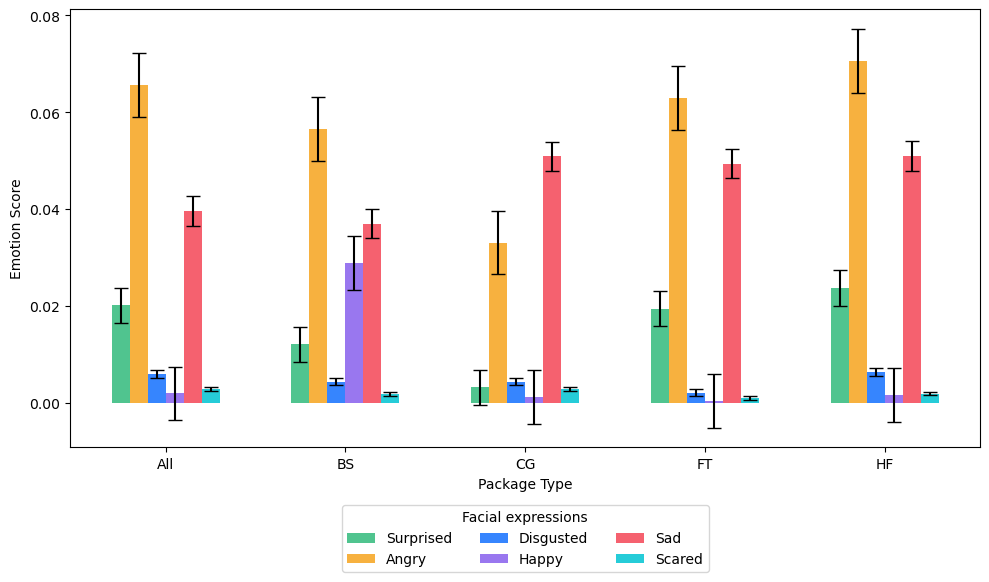

In [55]:
# Extract package types
package_types = merged_Viu['EventRene']

# Extract emotions and corresponding labels
emotions_Viu = ['total_ave_surprised', 'total_ave_angry', 'total_ave_disgusted',
                'total_ave_happy', 'total_ave_sad', 'total_ave_scared']
emotion_labels = ['Surprised', 'Angry', 'Disgusted', 'Happy', 'Sad', 'Scared']

# Calculate standard errors
std_errs = {}
for emotion in emotions_Viu:
    scores = merged_Viu[emotion]
    n = len(scores)
    if n > 1:
        std_err = np.std(scores, ddof=1) / np.sqrt(n)
    else:
        std_err = 0  # Handle case when there's only one sample
    std_errs[emotion] = std_err

# Define colors for each emotion
colors = ['#50c48f', '#f7b13f', '#3685fe', '#9977ef', '#f5616f', '#26ccd8']

# Plotting
x = np.arange(len(package_types))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with error bars for each emotion
bars = []
for i, (emotion, label, color) in enumerate(zip(emotions_Viu, emotion_labels, colors)):
    bar = ax.bar(x + i * width, merged_Viu[emotion], width, label=label, color=color, yerr=std_errs[emotion], capsize=5)
    bars.append(bar)

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Package Type')
ax.set_ylabel('Emotion Score')
ax.set_xticks(x + width * (len(emotions_Viu) - 1) / 2)
ax.set_xticklabels(package_types)

# Move legend to bottom center with title
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, title="Facial expressions")

fig.tight_layout()

plt.show()

### 4.2 EDA_AR, RMSSD and PFD for each Package Type

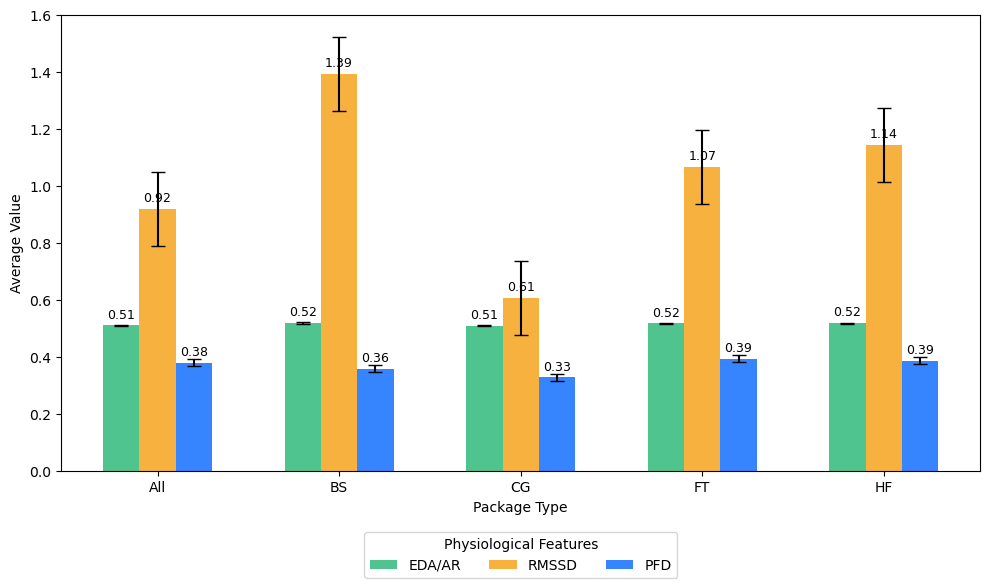

In [56]:
# Extract package types
package_types = merged_Viu['EventRene']

# Extract metrics and corresponding labels
metrics = ['EDA_AR_ave', 'RMSSD_ave', 'PFD_ave']
metric_labels = ['EDA/AR', 'RMSSD', 'PFD']

# Calculate standard errors
std_errs = {}
for metric in metrics:
    scores = merged_Viu[metric]
    n = len(scores)
    if n > 1:
        std_err = np.std(scores, ddof=1) / np.sqrt(n)
    else:
        std_err = 0  # Handle case when there's only one sample
    std_errs[metric] = std_err

# Define custom colors
colors = ['#50c48f', '#f7b13f', '#3685fe']

# Plotting
x = np.arange(len(package_types))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with error bars for each metric using custom colors
bars = []
for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
    bar = ax.bar(x + i * width, merged_Viu[metric], width, label=label, color=color, yerr=std_errs[metric], capsize=5)
    bars.append(bar)

    # Add value labels above bars
    for bar in bars[i]:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Package Type')
ax.set_ylabel('Average Value')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(package_types)

# Move legend to bottom center and add legend title
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(metrics), title='Physiological Features')

fig.tight_layout()

plt.show()

## 5. Study 2_Mixed Effects Model

We only perfomed the Mixed Effects Model in this file, and applied the ANOVA and Pearson's Chi-square test for goodness of fit in R script.

In [57]:
# Load the Excel file
file_path = 'preference.csv'

# Read the sheet into a DataFrame
preference = pd.read_csv(file_path)

In [58]:
# Merge edaar, rmssd, pfd, and emotions data frames on 'Session' and 'EventRene'
merged_df = pd.merge(edaar, rmssd, on=['Session', 'EventRene'], how='outer')
merged_df = pd.merge(merged_df, pfd, on=['Session', 'EventRene'], how='outer')
merged_df = pd.merge(merged_df, emotions, on=['Session', 'EventRene'], how='outer')

# Merge with preference data frame on 'Session'
model = pd.merge(merged_df, preference, on='Session', how='outer')
model

,Session,EventRene,EDA_AR,RMSSD,PFD,Ave_Surprised,Ave_Angry,Ave_Disgusted,Ave_Happy,Ave_Sad,Ave_Scared,Preference
0,Bram_C,All,0.539533,0.094525,0.183695,1.030411e-05,0.000908,0.003219,8.405784e-08,0.179722,0.000085,HF
1,Bram_C,BS,0.523518,0.124843,0.373570,1.335505e-10,0.005348,0.001372,1.473342e-07,0.135238,0.000258,HF
2,Bram_C,CG,0.446107,0.412983,0.375549,2.795039e-12,0.001390,0.001340,2.547238e-07,0.175252,0.000003,HF
3,Bram_C,FT,0.547256,0.142752,0.414721,3.248142e-06,0.005267,0.000550,3.354991e-08,0.117358,0.000443,HF
4,Bram_C,HF,0.516144,1.566579,0.337376,1.175168e-10,0.003523,0.001678,5.857692e-08,0.182575,0.000069,HF
...,...,...,...,...,...,...,...,...,...,...,...,...
75,Valentijn_C,All,0.504904,2.671505,0.362475,1.784479e-02,0.004894,0.000188,0.000000e+00,0.303555,0.001591,HF
76,Valentijn_C,BS,0.323679,2.665816,0.235156,1.461175e-04,0.006458,0.000484,0.000000e+00,0.406808,0.000166,HF
77,Valentijn_C,CG,0.365035,2.568189,0.275200,3.473375e-05,0.008424,0.000886,0.000000e+00,0.508226,0.000048,HF
78,Valentijn_C,FT,0.476376,2.237102,0.261818,1.648941e-04,0.005505,0.000335,1.904836e-07,0.522731,0.000013,HF


In [59]:
# Check for missing values in the 'Preference' column
missing_values_preference = model['Preference'].isnull().sum()

print(f'Missing values in Preference column: {missing_values_preference}')

Missing values in Preference column: 15


In [60]:
# Delete rows where the 'Preference' column has missing values
LMEM = model.dropna(subset=['Preference'])
# Convert the 'Preference' column to binary values
LMEM.loc[:, 'Preference'] = (LMEM['EventRene'] == LMEM['Preference']).astype(int)
LMEM

/var/folders/0r/j3pt0gxd59db062x60vqtsmr0000gn/T/ipykernel_68316/2320469730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMEM.loc[:, 'Preference'] = (LMEM['EventRene'] == LMEM['Preference']).astype(int)
/var/folders/0r/j3pt0gxd59db062x60vqtsmr0000gn/T/ipykernel_68316/2320469730.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  LMEM.loc[:, 'Preference'] = (LMEM['EventRene'] == LMEM['Preference']).astype(int)


,Session,EventRene,EDA_AR,RMSSD,PFD,Ave_Surprised,Ave_Angry,Ave_Disgusted,Ave_Happy,Ave_Sad,Ave_Scared,Preference
0,Bram_C,All,0.539533,0.094525,0.183695,1.030411e-05,0.000908,0.003219,8.405784e-08,0.179722,0.000085,0
1,Bram_C,BS,0.523518,0.124843,0.373570,1.335505e-10,0.005348,0.001372,1.473342e-07,0.135238,0.000258,0
2,Bram_C,CG,0.446107,0.412983,0.375549,2.795039e-12,0.001390,0.001340,2.547238e-07,0.175252,0.000003,0
3,Bram_C,FT,0.547256,0.142752,0.414721,3.248142e-06,0.005267,0.000550,3.354991e-08,0.117358,0.000443,0
4,Bram_C,HF,0.516144,1.566579,0.337376,1.175168e-10,0.003523,0.001678,5.857692e-08,0.182575,0.000069,1
...,...,...,...,...,...,...,...,...,...,...,...,...
75,Valentijn_C,All,0.504904,2.671505,0.362475,1.784479e-02,0.004894,0.000188,0.000000e+00,0.303555,0.001591,0
76,Valentijn_C,BS,0.323679,2.665816,0.235156,1.461175e-04,0.006458,0.000484,0.000000e+00,0.406808,0.000166,0
77,Valentijn_C,CG,0.365035,2.568189,0.275200,3.473375e-05,0.008424,0.000886,0.000000e+00,0.508226,0.000048,0
78,Valentijn_C,FT,0.476376,2.237102,0.261818,1.648941e-04,0.005505,0.000335,1.904836e-07,0.522731,0.000013,0


In [61]:
# check data type
print(LMEM.dtypes)

Session           object
EventRene         object
EDA_AR           float64
RMSSD            float64
PFD              float64
Ave_Surprised    float64
Ave_Angry        float64
Ave_Disgusted    float64
Ave_Happy        float64
Ave_Sad          float64
Ave_Scared       float64
Preference         int64
dtype: object


### 5.1 Heatmap

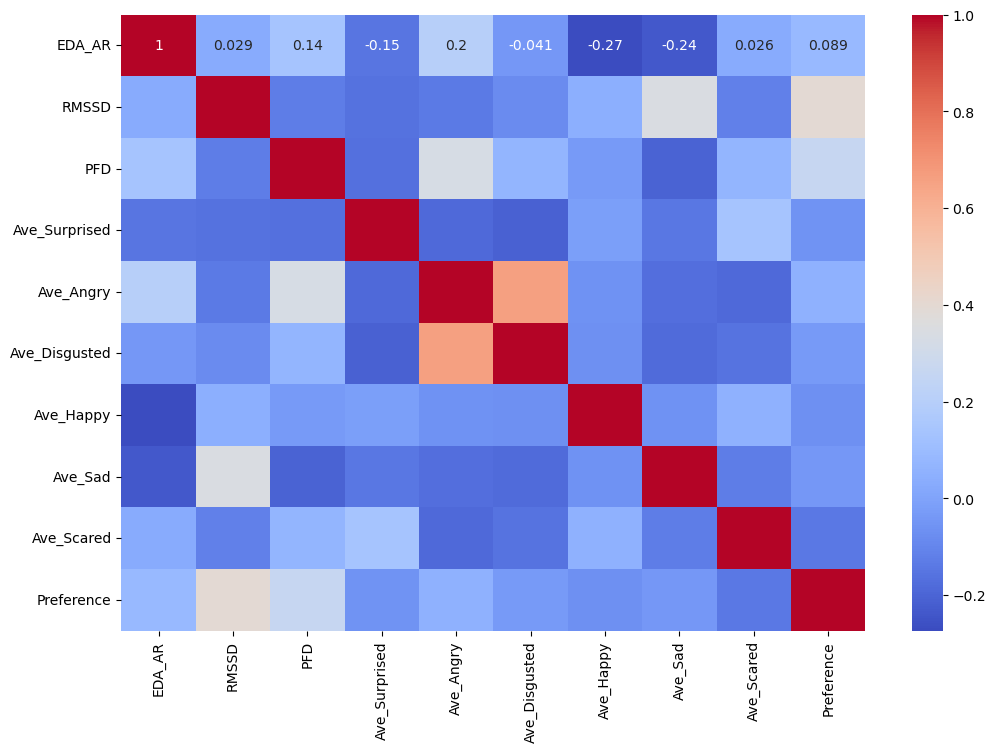

In [62]:
# Pearson Correlation Heatmap of Comparative Features
# Identify numeric columns (excluding 'ID' and 'Packaging type' columns)
numerical_columns = [col for col in LMEM.select_dtypes(include='number').columns if col not in ['ID', 'Packaging type']]

# Calculate the Pearson correlation matrix
pearson_correlation_matrix = LMEM[numerical_columns].corr(method='pearson')

# Generate Pearson correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pearson_correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.show()





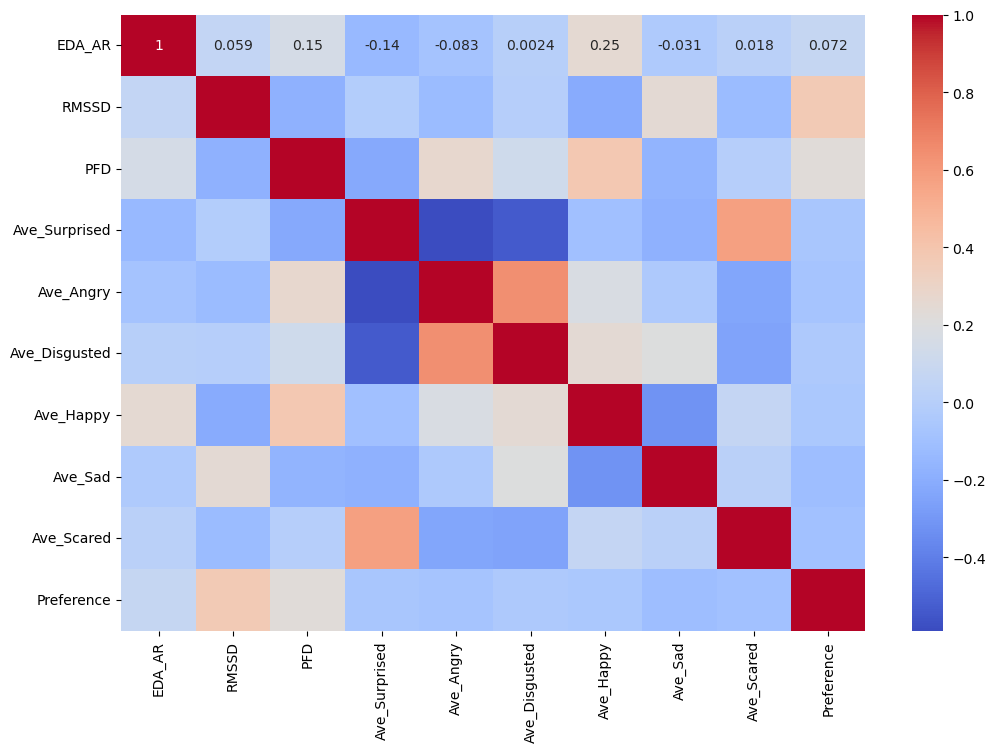

In [63]:
# Spearman Correlation Heatmap of Comparative Features
# Calculate the Spearman correlation matrix
spearman_correlation_matrix = LMEM[numerical_columns].corr(method='spearman')

# Generate Spearman correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.show()

